## 导入包

In [1]:
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch.autograd import Variable
from collections import defaultdict
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torch
import time
import glob
import sys
import cv2
import os


## 网络结构

In [2]:
# from https://github.com/usuyama/pytorch-unet

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
#         f = [16, 32, 64, 128]
#         f=[64,128,256,512]
        f=[32,64,128,256]
        self.dconv_down1 = double_conv(3, f[0])
        self.dconv_down2 = double_conv(f[0], f[1])
        self.dconv_down3 = double_conv(f[1], f[2])
        self.dconv_down4 = double_conv(f[2], f[3])        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(f[2] + f[3], f[2])
        self.dconv_up2 = double_conv(f[1] + f[2], f[1])
        self.dconv_up1 = double_conv(f[1] + f[0], f[0])
        
        self.conv_last = nn.Conv2d(f[0], n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

## 处理数据

In [3]:
batch_size = 8
image_size = 256
data_path = "data2/"
data_ratio = 0.1  # 验证集占比
classes = ['CK', 'PL', 'SL', 'AJ']
num_classes = 4

In [4]:

_ = [glob.glob(os.path.join(data_path, str(i), 'images', '*png')) for i in range(num_classes)]
data_ids = [[___[len(data_path):] for ___ in __] for __ in _]

val_ids = [data_ids[i][:int(len(data_ids[i]) * data_ratio)] for i in range(num_classes)]
train_ids = [data_ids[i][len(val_ids[i]):] for i in range(num_classes)]
val_ids = sum(val_ids, [])  # 二维列表转一维
train_ids = sum(train_ids, [])
# train_ids = train_ids[:120]
# val_ids = val_ids[:30]
print(len(train_ids))
print(len(val_ids))
print(train_ids[0])


4610
511
0\images\007209.png


In [5]:


class MyDataset(Dataset):
    def __init__(self, ids, transform=None, data_path='data/', image_size=572, num_classes=1):
        super(MyDataset, self).__init__()
        self.ids = ids
        self.transform = transform
        self.data_path = data_path
        self.image_size = image_size
        self.num_classes = num_classes
        self.images = []
        self.masks = []
        self.load_images_and_masks()

    def load_images_and_masks(self):
        for id in self.ids:
            current_class = int(id[0])  # get this image's class.
            image_path = os.path.join(self.data_path, id)
            mask_path = image_path.replace('images', 'masks')
            # Reading Image
            image = cv2.imread(image_path, 1)  # 三通道
            image = cv2.resize(image, (self.image_size, self.image_size))
            # Reading Masks
            mask = np.zeros((self.image_size, self.image_size))
            mask = [mask] * 4
            mask = np.array(mask)
            mask_image = cv2.imread(mask_path, -1)  # 原通道
            mask_image = cv2.resize(mask_image, (self.image_size, self.image_size))
            # mask_image = np.expand_dims(mask_image, axis=-1)
            mask[current_class] = np.maximum(mask[current_class], mask_image)  # 将该图像的mask添加到对应的通道

            # Normalization
            image = image / 255.0
            mask = mask / 255.0
            self.images.append(image)
            self.masks.append(mask)
        self.images = np.array(self.images)
        self.masks = np.array(self.masks)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            image = self.transform(image)

        return image, mask



(256, 256, 3) (4, 256, 256)


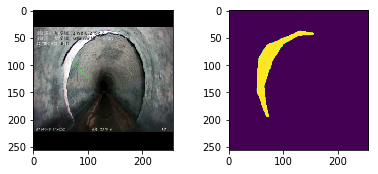

In [8]:
d=MyDataset(ids=train_ids[:10],data_path=data_path, image_size=image_size)
x,y=d.__getitem__(0)
print(x.shape,y.shape)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(y[0])
# plt.savefig("result.jpg", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

trans = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MyDataset(ids=train_ids, data_path=data_path, image_size=image_size, transform=trans,
                          num_classes=num_classes)
val_dataset = MyDataset(ids=val_ids, data_path=data_path, image_size=image_size, transform=trans,
                        num_classes=num_classes)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)
print(len(train_dataloader))
print(len(val_dataloader))

## 训练

In [ ]:
lr = 1e-4
model = UNet(n_class=num_classes).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model, input_size=(3, image_size, image_size))

In [ ]:
epochs = 300
best_loss = 1e9 + 7

# 相似度损失
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()


def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    print('Epoch {}/{} '.format(epoch + 1, epochs))
    # train
    model.train()
    metrics = defaultdict(float)  # 有默认值的dict.
    bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), ncols=80)
    total_nums = 0
    for index, (images, masks) in bar:
        images, masks = Variable(images).cuda(), Variable(masks).cuda()
        images = images.type(torch.cuda.FloatTensor)
        masks = masks.type(torch.cuda.FloatTensor)
        # 从[batch_size,image_size,image_size,channels]变到[barch_size,channels,image_size,image_size]
        masks = masks.view(masks.size(0), masks.size(3), masks.size(1), masks.size(2))
        total_nums += images.size(0)
        optimizer.zero_grad()
        torch.set_grad_enabled(True)
        out = model(images)
        loss = calc_loss(out, masks, metrics)
        loss.backward()
        optimizer.step()
    current_loss = metrics['loss'] / total_nums
    current_acc = 1 - metrics['dice'] / total_nums
    print('train loss:{}'.format(current_loss))
    print('train acc:{}'.format(current_acc))
    train_loss.append(current_loss)
    train_acc.append(current_acc)
    # eval
    model.eval()
    metrics = defaultdict(float)
    bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), ncols=80)
    total_nums = 0
    for index, (images, masks) in bar:
        images, masks = Variable(images).cuda(), Variable(masks).cuda()
        images = images.type(torch.cuda.FloatTensor)
        masks = masks.type(torch.cuda.FloatTensor)
        masks = masks.view(masks.size(0), masks.size(3), masks.size(1), masks.size(2))
        total_nums += images.size(0)
        optimizer.zero_grad()
        torch.set_grad_enabled(False)
        out = model(images)
        loss = calc_loss(out, masks, metrics)
    current_loss = metrics['loss'] / total_nums
    current_acc = 1 - metrics['dice'] / total_nums
    print('eval loss:{}'.format(current_loss))
    print('val acc:{}'.format(current_acc))
    val_loss.append(current_loss)
    val_acc.append(current_acc)
    if current_loss < best_loss:
        best_loss = current_loss
        torch.save(model.state_dict(), 'best.weight')
print('best loss: ', best_loss)
print(train_loss)
print(val_loss)
print(train_acc)
print(val_acc)
        

## 测试

In [6]:
model=UNet(n_class=num_classes).cuda()
model.load_state_dict(torch.load(r'best.weight'))

video = cv2.VideoCapture('test3.mp4')
flag, image = video.read()
h, w = image.shape[:2]
out = cv2.VideoWriter('out.avi', cv2.VideoWriter_fourcc(*'XVID'), video.get(cv2.CAP_PROP_FPS), (w,h))
current_frame = 0
total_frame = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
import time
start=time.time()
while flag:
    h, w = image.shape[:2]
    image2 = cv2.resize(image, (image_size, image_size)) / 255.0
    image2 = np.array(image2)
    image2=trans(image2)
    image2=torch.unsqueeze(image2,0).cuda()
    image2 = image2.type(torch.cuda.FloatTensor)
    result = model(image2) # result:(1, num_classes, image_size, image_size)
    result = result > 0.2
#     result = result.view(result.size(1), result.size(2), result.size(3), result.size(0))
    result=result.cpu().numpy()[0]

    
    for i in range(4):
        img=result[i]*240.0 #(image_size,image_size)
        img=np.expand_dims(img, axis=-1)#to (image_size, image_size, 1)
        img=cv2.resize(img,(w,h))
        img2 = np.zeros_like(image)
        #draw color
        if i==3:
            img2[:,:,0] = img#blue
            img2[:,:,1] = img#green
        else:
            img2[:,:,i] = img
        image=cv2.add(image,img2)
    current_frame+=1
    out.write(image)
    flag, image = video.read()
    sys.stdout.write("\r" + '{}/{}'.format(current_frame,total_frame))
    sys.stdout.flush()
print('\n')
total_time=time.time()-start
print('FPS:{}'.format(total_frame/total_time))
#     fig = plt.figure()
#     fig.subplots_adjust(hspace=0.4, wspace=0.4)

#     ax = fig.add_subplot(1, 2, 1)
#     ax.imshow(img2)

#     ax = fig.add_subplot(1, 2, 2)
#     ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
#     plt.show()
#     time.sleep(1)
out.release()

170/171

FPS:17.977304750721693
